<a href="https://colab.research.google.com/github/IsraelAlvarado/tareas-bigdata/blob/main/1_4_Foro_An%C3%A1lisis_RFM_con_SPARK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans, GaussianMixture
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.stat import Correlation
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

**Hipótesis/Objetivo:**
"Identificar grupos de sesiones de hacking basados en características técnicas y de comportamiento
para detectar patrones de ataque y perfiles de atacantes que puedan ayudar en la seguridad informática."

In [2]:
spark = SparkSession.builder.appName("Colab_Spark").getOrCreate()

print('Spark iniciado:', spark)

Spark iniciado: <pyspark.sql.session.SparkSession object at 0x7e3f7becd6a0>


In [3]:
df = spark.read.csv("/content/hack_data.csv", header=True, inferSchema=True)

print("=== ESTRUCTURA DEL DATASET ===")
print(f"Número de registros: {df.count()}")
print(f"Número de variables: {len(df.columns)}")
df.printSchema()

=== ESTRUCTURA DEL DATASET ===
Número de registros: 334
Número de variables: 7
root
 |-- Session_Connection_Time: double (nullable = true)
 |-- Bytes Transferred: double (nullable = true)
 |-- Kali_Trace_Used: integer (nullable = true)
 |-- Servers_Corrupted: double (nullable = true)
 |-- Pages_Corrupted: double (nullable = true)
 |-- Location: string (nullable = true)
 |-- WPM_Typing_Speed: double (nullable = true)



In [4]:
print("\n=== ESTADÍSTICAS DESCRIPTIVAS ===")
df.describe().show()


=== ESTADÍSTICAS DESCRIPTIVAS ===
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|summary|Session_Connection_Time| Bytes Transferred|   Kali_Trace_Used|Servers_Corrupted|   Pages_Corrupted|   Location|  WPM_Typing_Speed|
+-------+-----------------------+------------------+------------------+-----------------+------------------+-----------+------------------+
|  count|                    334|               334|               334|              334|               334|        334|               334|
|   mean|     30.008982035928145| 607.2452694610777|0.5119760479041916|5.258502994011977|10.838323353293413|       null|57.342395209580864|
| stddev|     14.088200614636158|286.33593163576757|0.5006065264451406| 2.30190693339697|  3.06352633036022|       null| 13.41106336843464|
|    min|                    1.0|              10.0|                 0|              1.0|               6.0|Afghanistan|     

In [5]:
print("\n=== INFORMACIÓN SOBRE VALORES NULOS ===")
from pyspark.sql.functions import col, sum as spark_sum

null_counts = df.select([spark_sum(col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()


=== INFORMACIÓN SOBRE VALORES NULOS ===
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|Session_Connection_Time|Bytes Transferred|Kali_Trace_Used|Servers_Corrupted|Pages_Corrupted|Location|WPM_Typing_Speed|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+
|                      0|                0|              0|                0|              0|       0|               0|
+-----------------------+-----------------+---------------+-----------------+---------------+--------+----------------+



In [6]:
df_clean = df.dropDuplicates()
print(f"Registros después de eliminar duplicados: {df_clean.count()}")

Registros después de eliminar duplicados: 334


In [7]:
def remove_outliers_iqr(df, columns):
    for column in columns:
        quantiles = df.approxQuantile(column, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        df = df.filter((col(column) >= lower_bound) & (col(column) <= upper_bound))

    return df

numeric_columns = ['Session_Connection_Time', 'Bytes Transferred', 'Servers_Corrupted',
                   'Pages_Corrupted', 'WPM_Typing_Speed']

In [8]:
df_clean = remove_outliers_iqr(df_clean, numeric_columns)
print(f"Registros después de eliminar outliers: {df_clean.count()}")

Registros después de eliminar outliers: 334


In [9]:
assembler = VectorAssembler(inputCols=numeric_columns, outputCol="features_vector")
df_vector = assembler.transform(df_clean)

In [10]:
correlation_matrix = Correlation.corr(df_vector, "features_vector").collect()[0][0]
correlation_array = correlation_matrix.toArray()

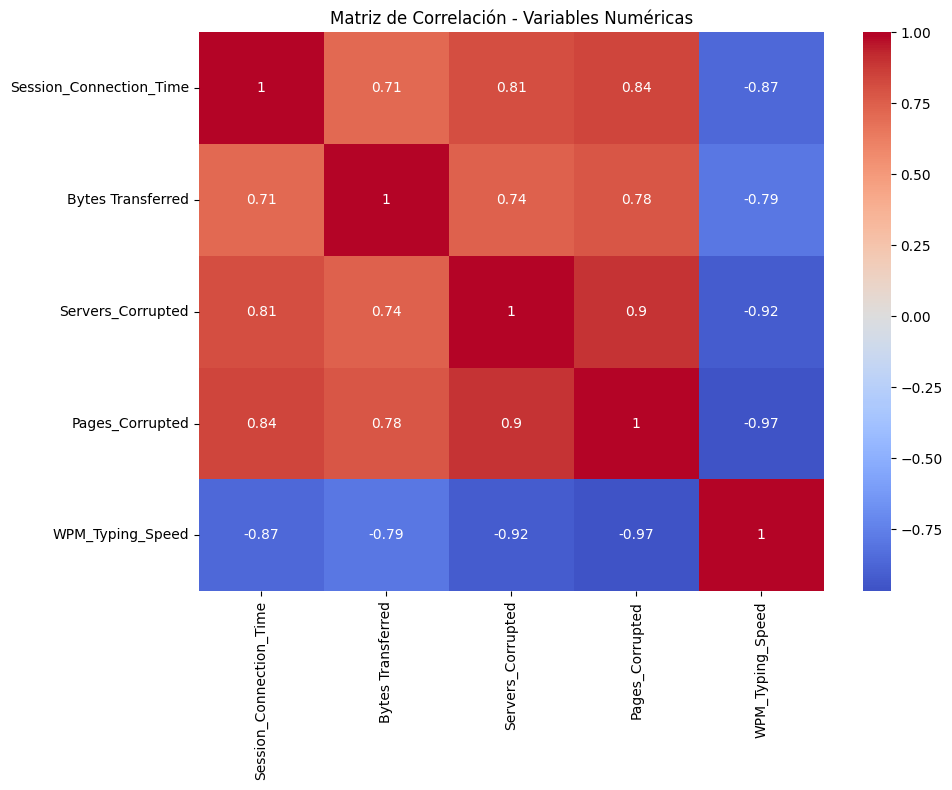

In [11]:
corr_df = pd.DataFrame(correlation_array, index=numeric_columns, columns=numeric_columns)
plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlación - Variables Numéricas')
plt.tight_layout()
plt.show()

In [12]:
features_for_clustering = ['Session_Connection_Time', 'Bytes Transferred', 'Kali_Trace_Used',
                          'Servers_Corrupted', 'Pages_Corrupted', 'WPM_Typing_Speed']

assembler = VectorAssembler(inputCols=features_for_clustering, outputCol="features")
df_features = assembler.transform(df_clean)

In [13]:
scaler = StandardScaler(inputCol="features", outputCol="scaled_features",
                       withStd=True, withMean=True)

scaler_model = scaler.fit(df_features)
df_scaled = scaler_model.transform(df_features)

In [15]:
def find_optimal_k(df, max_k=10):
    silhouette_scores = []
    cost_values = []

    for k in range(2, max_k + 1):
        kmeans = KMeans(featuresCol='scaled_features', k=k, seed=42)
        model = kmeans.fit(df)

        # Silhouette Score
        predictions = model.transform(df)
        evaluator = ClusteringEvaluator(featuresCol='scaled_features',
                                      metricName='silhouette',
                                      distanceMeasure='squaredEuclidean')
        silhouette = evaluator.evaluate(predictions)
        silhouette_scores.append(silhouette)

        # Cost (Within-Cluster Sum of Squares)
        cost = model.summary.trainingCost
        cost_values.append(cost)

        print(f"K={k}, Silhouette Score: {silhouette:.4f}, WCSS: {cost:.2f}")

    return silhouette_scores, cost_values

print("=== BÚSQUEDA DE K ÓPTIMO PARA K-MEANS ===")
silhouette_scores, cost_values = find_optimal_k(df_scaled)

=== BÚSQUEDA DE K ÓPTIMO PARA K-MEANS ===
K=2, Silhouette Score: 0.8176, WCSS: 601.77
K=3, Silhouette Score: 0.7608, WCSS: 434.76
K=4, Silhouette Score: 0.7196, WCSS: 267.13
K=5, Silhouette Score: 0.6295, WCSS: 248.81
K=6, Silhouette Score: 0.5276, WCSS: 232.67
K=7, Silhouette Score: 0.5060, WCSS: 225.33
K=8, Silhouette Score: 0.3793, WCSS: 193.31
K=9, Silhouette Score: 0.4419, WCSS: 190.24
K=10, Silhouette Score: 0.4528, WCSS: 186.70


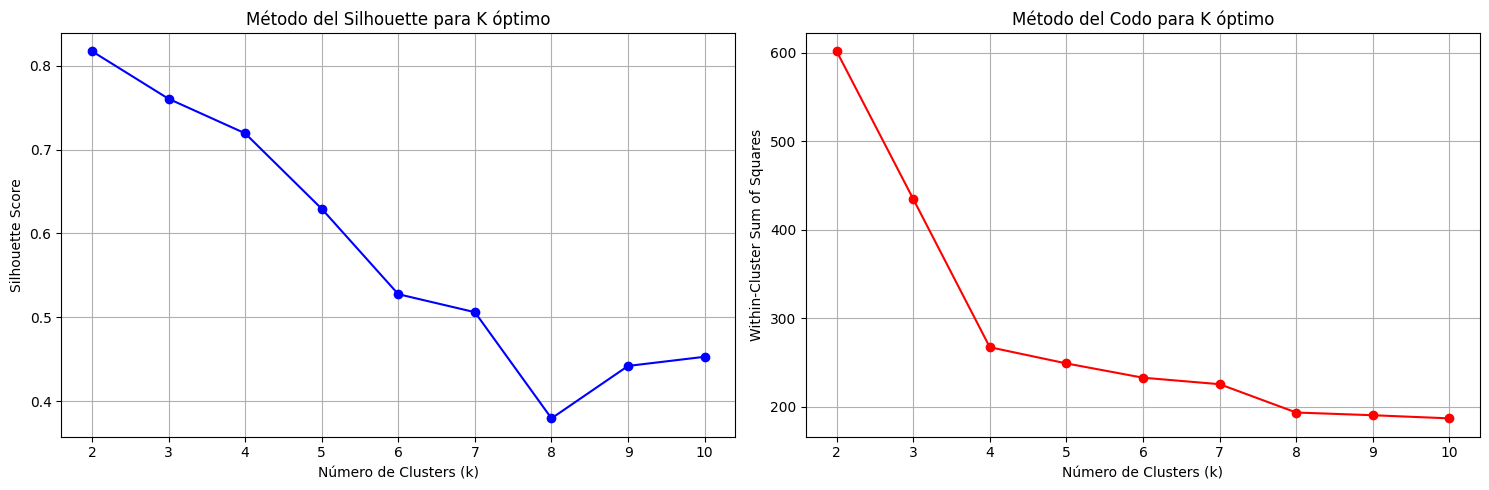

In [19]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(range(2, 11), silhouette_scores, 'bo-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Método del Silhouette para K óptimo')
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(2, 11), cost_values, 'ro-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares')
plt.title('Método del Codo para K óptimo')
plt.grid(True)

plt.tight_layout()
plt.show()

In [20]:
optimal_k = 3  # Basado en el análisis visual
kmeans = KMeans(featuresCol='scaled_features', k=optimal_k, seed=42)
kmeans_model = kmeans.fit(df_scaled)
kmeans_predictions = kmeans_model.transform(df_scaled)

In [21]:
print("=== RESULTADOS K-MEANS ===")
print(f"Centros de clusters K-means:")
centers = kmeans_model.clusterCenters()
for i, center in enumerate(centers):
    print(f"Cluster {i}: {center}")

=== RESULTADOS K-MEANS ===
Centros de clusters K-means:
Cluster 0: [-0.86984075 -0.80244614 -0.02990384 -0.91949279 -0.97535442  0.99101306]
Cluster 1: [ 0.80711264  0.76417781 -1.02271149  0.91497207  0.9907192  -0.97167955]
Cluster 2: [ 0.92615349  0.83680065  0.97486534  0.92355116  0.96156104 -1.00836928]


In [24]:
def find_optimal_gmm_components(df, max_components=8):
    log_likelihoods = []
    for k in range(2, max_components + 1):
        gmm = GaussianMixture(featuresCol='scaled_features', k=k, seed=42)
        gmm_model = gmm.fit(df)

        log_likelihood = gmm_model.summary.logLikelihood

        log_likelihoods.append(log_likelihood)

        print(f"GMM Components={k}, Log-Likelihood: {log_likelihood:.2f}")
    return log_likelihoods
print("\n=== BÚSQUEDA DE COMPONENTES ÓPTIMOS PARA GMM ===")
log_likelihoods = find_optimal_gmm_components(df_scaled)


=== BÚSQUEDA DE COMPONENTES ÓPTIMOS PARA GMM ===
GMM Components=2, Log-Likelihood: -1112.24
GMM Components=3, Log-Likelihood: -1025.63
GMM Components=4, Log-Likelihood: 1484.46
GMM Components=5, Log-Likelihood: 1945.80
GMM Components=6, Log-Likelihood: 2032.18
GMM Components=7, Log-Likelihood: 1602.74
GMM Components=8, Log-Likelihood: 2285.19


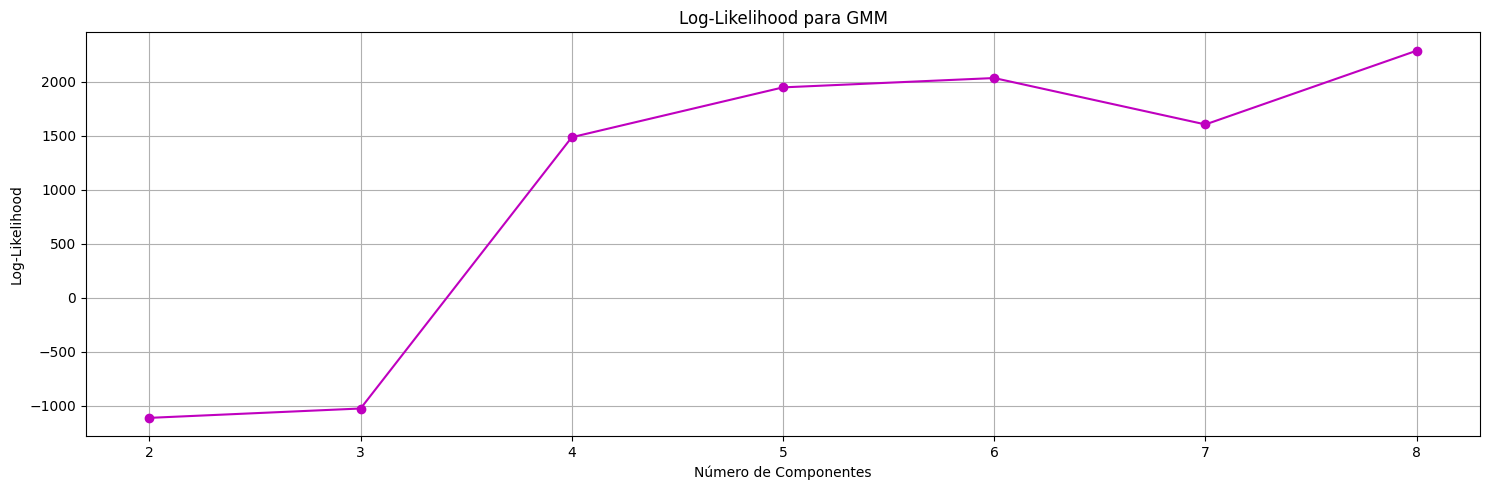

In [27]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1) # Adjusted subplot to take the full figure width
plt.plot(range(2, 9), log_likelihoods, 'mo-')
plt.xlabel('Número de Componentes')
plt.ylabel('Log-Likelihood')
plt.title('Log-Likelihood para GMM')
plt.grid(True)

plt.tight_layout()
plt.show()

In [28]:
optimal_components = 3  # Basado en el análisis BIC
gmm = GaussianMixture(featuresCol='scaled_features', k=optimal_components, seed=42)
gmm_model = gmm.fit(df_scaled)
gmm_predictions = gmm_model.transform(df_scaled)

print("=== RESULTADOS GMM ===")
print(f"Pesos de los componentes GMM: {gmm_model.weights}")

=== RESULTADOS GMM ===
Pesos de los componentes GMM: [0.4940119785679194, 0.017964061809630442, 0.48802395962245015]


In [30]:
evaluator = ClusteringEvaluator(featuresCol='scaled_features',
                              metricName='silhouette',
                              distanceMeasure='squaredEuclidean')

kmeans_silhouette = evaluator.evaluate(kmeans_predictions)
gmm_silhouette = evaluator.evaluate(gmm_predictions)

print("\n=== COMPARACIÓN DE MODELOS ===")
print(f"K-means Silhouette Score: {kmeans_silhouette:.4f}")
print(f"GMM Silhouette Score: {gmm_silhouette:.4f}")
print(f"GMM Log-Likelihood: {gmm_model.summary.logLikelihood:.2f}")


=== COMPARACIÓN DE MODELOS ===
K-means Silhouette Score: 0.7608
GMM Silhouette Score: 0.7155
GMM Log-Likelihood: -1025.63


In [31]:
kmeans_pd = kmeans_predictions.select("*").toPandas()
gmm_pd = gmm_predictions.select("*").toPandas()

In [32]:
plt.figure(figsize=(15, 10))

<Figure size 1500x1000 with 0 Axes>

<Figure size 1500x1000 with 0 Axes>

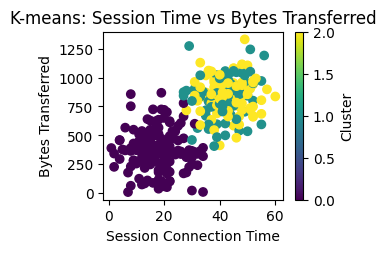

In [33]:
plt.subplot(2, 2, 1)
scatter = plt.scatter(kmeans_pd['Session_Connection_Time'],
                     kmeans_pd['Bytes Transferred'],
                     c=kmeans_pd['prediction'], cmap='viridis')
plt.xlabel('Session Connection Time')
plt.ylabel('Bytes Transferred')
plt.title('K-means: Session Time vs Bytes Transferred')
plt.colorbar(scatter, label='Cluster')

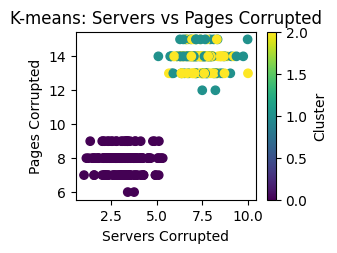

In [34]:
plt.subplot(2, 2, 2)
scatter = plt.scatter(kmeans_pd['Servers_Corrupted'],
                     kmeans_pd['Pages_Corrupted'],
                     c=kmeans_pd['prediction'], cmap='viridis')
plt.xlabel('Servers Corrupted')
plt.ylabel('Pages Corrupted')
plt.title('K-means: Servers vs Pages Corrupted')
plt.colorbar(scatter, label='Cluster')

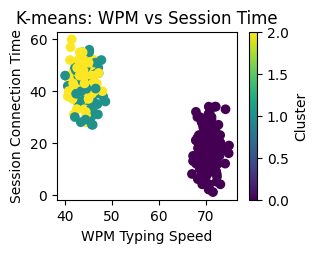

In [35]:
plt.subplot(2, 2, 3)
scatter = plt.scatter(kmeans_pd['WPM_Typing_Speed'],
                     kmeans_pd['Session_Connection_Time'],
                     c=kmeans_pd['prediction'], cmap='viridis')
plt.xlabel('WPM Typing Speed')
plt.ylabel('Session Connection Time')
plt.title('K-means: WPM vs Session Time')
plt.colorbar(scatter, label='Cluster')

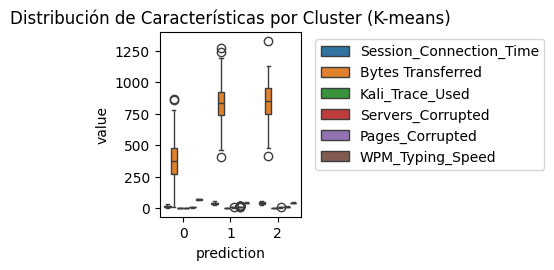

In [36]:
plt.subplot(2, 2, 4)
kmeans_melted = kmeans_pd.melt(id_vars=['prediction'],
                              value_vars=features_for_clustering,
                              var_name='feature', value_name='value')
sns.boxplot(data=kmeans_melted, x='prediction', y='value', hue='feature')
plt.title('Distribución de Características por Cluster (K-means)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

In [37]:
print("\n=== CARACTERIZACIÓN DE CLUSTERS K-MEANS ===")
cluster_profiles = kmeans_pd.groupby('prediction')[features_for_clustering].mean()
print(cluster_profiles.round(2))


=== CARACTERIZACIÓN DE CLUSTERS K-MEANS ===
            Session_Connection_Time  Bytes Transferred  Kali_Trace_Used  \
prediction                                                                
0                             17.75             377.48              0.5   
1                             41.38             826.06              0.0   
2                             43.06             846.85              1.0   

            Servers_Corrupted  Pages_Corrupted  WPM_Typing_Speed  
prediction                                                        
0                        3.14             7.85             70.63  
1                        7.36            13.87             44.31  
2                        7.38            13.78             43.82  


In [38]:
location_analysis = kmeans_predictions.groupBy('prediction', 'Location').count().orderBy('prediction', desc('count'))
print("\n=== UBICACIONES MÁS COMUNES POR CLUSTER ===")
location_analysis.show(20)


=== UBICACIONES MÁS COMUNES POR CLUSTER ===
+----------+--------------------+-----+
|prediction|            Location|count|
+----------+--------------------+-----+
|         0|    Saint Barthelemy|    3|
|         0|           Sri Lanka|    3|
|         0|Palestinian Terri...|    3|
|         0|              Bhutan|    3|
|         0|United States Vir...|    3|
|         0|           Australia|    2|
|         0|     Kyrgyz Republic|    2|
|         0|              Sweden|    2|
|         0|Netherlands Antilles|    2|
|         0|         Saint Lucia|    2|
|         0|             Mayotte|    2|
|         0|            Mongolia|    2|
|         0|               Haiti|    2|
|         0|Sao Tome and Prin...|    2|
|         0|              Norway|    2|
|         0|       Faroe Islands|    2|
|         0|Bouvet Island (Bo...|    2|
|         0|                Niue|    2|
|         0|            Ethiopia|    2|
|         0|Holy See (Vatican...|    2|
+----------+--------------------+--